In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


class DataSimulator:
    def __init__(self, n_samples=100, linear_coef=1, quad_coef=0.1, base_noise_std=1,
                 noise_increase_func=np.ones_like, xmin=0, xmax=10, ymin=0, ymax=20, random_state=None):
        self.n_samples = n_samples
        self.linear_coef = linear_coef
        self.quad_coef = quad_coef
        self.base_noise_std = base_noise_std
        self.noise_increase_func = noise_increase_func
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.random_state = random_state
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

    def generate_data(self, filter=True):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Simulate data
        X = np.random.randn(self.n_samples, 1) + 5
        noise = np.random.randn(self.n_samples) * self.base_noise_std * self.noise_increase_func(X.squeeze())
        y = self.quad_coef * X.squeeze()**2 + self.linear_coef * X.squeeze() + noise

        # Filter data if needed
        if filter:
            mask = (X.squeeze() >= self.xmin) & (X.squeeze() <= self.xmax) & (y >= self.ymin) & (y <= self.ymax)
            X = X[mask]
            y = y[mask]

        print(f"Number of samples: {len(X)}")
        self.X_train = X
        self.y_train = y

        return self.X_train, self.y_train
    
    def split_data(self, test_size=0.2):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        # Make sure data is generated before split
        if self.X_train is None or self.y_train is None:
            self.generate_data()

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_train, self.y_train, test_size=test_size, random_state=self.random_state
        )
        
        # Assign the split data to class variables
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        return self.X_train, self.X_test, self.y_train, self.y_test

class DataPlotter:
    @staticmethod
    def scatter_plot(X, y):
        plt.scatter(X, y, color='blue', label='Training data')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title('Scatter Plot of X vs y')
        plt.legend()
        plt.show()

class ConformalPredictor:
    def __init__(self, model, alpha=0.05, ymin=0, ymax=20):
        self.model = model
        self.alpha = alpha
        self.ymin = ymin
        self.ymax = ymax
        self.ys = []

    @staticmethod
    def calculate_nonconformity_scores(X, y, model):
        y_pred = model.predict(X)
        return np.abs(y - y_pred)

    def predict_interval(self, X_train, y_train, X_new, y_range):
        self.ys = []
        for i, y_hypothesis in enumerate(y_range):
            # Augment the training data with the new point and hypothesized outcome
            X_augmented = np.vstack([X_train, X_new])
            y_augmented = np.append(y_train, y_hypothesis)

            # Refit the model on the augmented data
            self.model.fit(X_augmented, y_augmented)

            # Calculate the nonconformity scores for the augmented data
            augmented_scores = self.calculate_nonconformity_scores(X_augmented, y_augmented, self.model)
            # Number of scores
            n = len(augmented_scores) - 1

            # Calculate the conformal quantile
            conformal_quantile = np.quantile(augmented_scores[:-1], min(1, (1 - self.alpha) * (1 + 1/n)), method='higher')

            # Get the nonconformity score for predicted y
            y_hypothesis_score = augmented_scores[-1]

            # Update the bounds of the interval
            if y_hypothesis_score <= conformal_quantile:
                if i == 0:
                    self.ys.append([y_range[0], y_range[1]])
                elif i == (len(y_range) - 1):
                    self.ys.append([y_range[n-2], y_range[n-1]])
                else:
                    self.ys.append([y_range[i-1], y_range[i+1]])
        return self.ys
    
    def test_coverage(self, X_train, y_train, X_test, y_test, y_range):
        coverage_count = 0
        for x_new, y_true in zip(X_test, y_test):
            self.predict_interval(X_train, y_train, np.array([x_new]), y_range)
            for i, interval in enumerate(self.ys):
                if (interval[0] < y_true) and (y_true < interval[1]):
                    coverage_count += 1
                    break
        return coverage_count / len(X_test)

In [46]:
# Set the data parameters
n_samples=1000
linear_coef=1
quad_coef=0
base_noise_std=0.5
noise_increase_func=np.sqrt
filter = True
xmin=2
xmax=8
ymin=0
ymax=20
random_state=3

simulator = DataSimulator(n_samples=n_samples, linear_coef=linear_coef, quad_coef=quad_coef, base_noise_std=base_noise_std,
                          noise_increase_func=noise_increase_func, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, random_state=random_state)

# Perform a train-test split
X_train, X_test, y_train, y_test = simulator.split_data(test_size=0.2)

Number of samples: 998


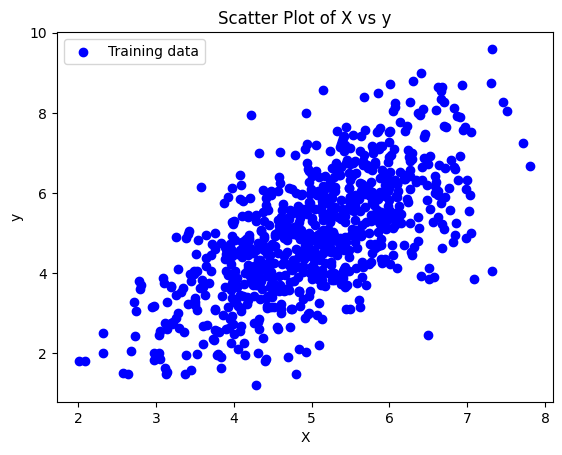

In [47]:
# Plot the data
plotter = DataPlotter()
plotter.scatter_plot(X_train, y_train)

In [48]:
# Set the ACI configurations
# Initialize the linear regression model
model = LinearRegression()

# Initialize conformal predictor
conformal_predictor = ConformalPredictor(model=model, alpha=0.05)

In [49]:

# New data point for which we want the prediction interval
X_new = np.array([[2]])
# Range of possible y values
y_range = np.linspace(simulator.ymin, simulator.ymax, 1000)
'''
# Calculate conformal prediction interval
lower_bound, upper_bound = conformal_predictor.predict_interval(X_train, y_train, X_new, y_range)

# Print the conformal prediction interval
print(f"Conformal prediction interval for the new data point at X_new={X_new[0][0]}: [{lower_bound}, {upper_bound}]")
'''

'\n# Calculate conformal prediction interval\nlower_bound, upper_bound = conformal_predictor.predict_interval(X_train, y_train, X_new, y_range)\n\n# Print the conformal prediction interval\nprint(f"Conformal prediction interval for the new data point at X_new={X_new[0][0]}: [{lower_bound}, {upper_bound}]")\n'

In [50]:
# Test the real coverage probability
a = conformal_predictor.predict_interval(X_train, y_train, X_new, y_range)
# print(a)
coverage_probability = conformal_predictor.test_coverage(X_train, y_train, X_test, y_test, y_range)
print(coverage_probability)

0.965


## ACI

In [51]:
import bisect
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming ConformalPredictor is defined somewhere else
# from some_module import ConformalPredictor

class ACI_Base:
    def __init__(self, X, y, ymin=0, ymax=20, model=LinearRegression(), predictor=ConformalPredictor, alpha=0.05, gamma=0.1):
        self.X = X
        self.y = y
        self.ymin = ymin
        self.ymax = ymax
        self.model = model
        self.predictor = predictor
        self.alpha = alpha
        self.gamma = gamma
        self.current_predictor = None

    def predict_intervals(self):
        raise NotImplementedError("Subclasses should implement this method.")

    def coverage_probability(self):
        raise NotImplementedError("Subclasses should implement this method.")

    def plot_coverage_probabilities(self, coverage_list):
        cumulative_means = [np.mean(coverage_list[:i+1]) for i in range(len(coverage_list))]
        plt.plot(cumulative_means, marker='o')
        plt.title('Cumulative Mean of Coverage Probability')
        plt.xlabel('Number of Terms')
        plt.ylabel('Cumulative Mean')
        plt.grid(True)
        plt.show()

class ACI(ACI_Base):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.coverage = []
        self.alpha_tilde = [self.alpha]

    def predict_intervals(self):
        n = self.X.shape[0]
        for i in range(2, n):
            if i % 10 ==0:
                print(i)
            # Update alpha tilde
            if self.coverage:
                self.alpha_tilde[-1] = self.alpha_tilde[-1] + self.gamma * (self.alpha + self.coverage[-1] - 1)
            self.alpha_tilde[-1] = min(1, max(0, self.alpha_tilde[-1]))
            # New data point for which we want the prediction interval
            X_new = self.X[i]
            # Range of possible y values
            y_range = np.linspace(self.ymin, self.ymax, 1000) 
            # Initialize conformal predictor
            self.current_predictor = self.predictor(model=self.model, alpha=self.alpha_tilde[-1])
            # Generate the predicted interval
            intervals = self.current_predictor.predict_interval(self.X[0:i], self.y[0:i], X_new, y_range)
            coverage = 0
            for i, interval in enumerate(intervals):
                if (interval[0] < self.y[i]) and (self.y[i] < interval[1]):
                    coverage = 1
                    break
            self.coverage.append(coverage)
            self.alpha_tilde.append(self.alpha_tilde[-1])

    def coverage_probability(self):
        return np.mean(self.coverage)


class ACI_Binned(ACI_Base):
    def __init__(self, X, y, *args, **kwargs):
        super().__init__(X, y, *args, **kwargs)
        self.coverage = None
        self.alpha_tilde = None
        self.coverage_all = []

    def predict_intervals(self, cutoffs):
        n = self.X.shape[0]
        l = len(cutoffs) + 1
        y_range = np.linspace(self.ymin, self.ymax, 1000) 
        for i in range(l):
            self.coverage = [[] for _ in range(l)]
            self.alpha_tilde = [[self.alpha] for _ in range(l)]
        for i in range(2, n):
            # Update alpha tilde 
            group_index =  bisect.bisect_left(cutoffs, self.X[i])
            if self.coverage[group_index]:
                self.alpha_tilde[group_index][-1] = self.alpha_tilde[group_index][-1] + self.gamma * (self.alpha + self.coverage[group_index][-1] - 1)
            self.alpha_tilde[group_index][-1] = min(1, max(0, self.alpha_tilde[group_index][-1]))
            # Initialize conformal predictor
            self.current_predictor = self.predictor(model=self.model, alpha=self.alpha_tilde[group_index][-1])
            # Generate the predicted interval
            intervals = self.current_predictor.predict_interval(self.X[0:i], self.y[0:i], self.X[i], y_range)
            coverage = 0
            for i, interval in enumerate(intervals):
                if (interval[0] < self.y[i]) and (self.y[i] < interval[1]):
                    coverage = 1
                    break
            self.coverage[group_index].append(coverage)
            self.coverage_all.append(coverage)
            self.alpha_tilde[group_index].append(self.alpha_tilde[group_index][-1])

    def coverage_probability(self):
        return np.mean(self.coverage_all)


In [52]:
ACI_model_1 = ACI(X=X_train, y=y_train, ymin =0, ymax = ymax)
ACI_model_1.predict_intervals()
ACI_model_1.coverage_probability()

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790


0.8492462311557789

In [53]:
np.mean(ACI_model_1.coverage[200:800])

0.8557046979865772

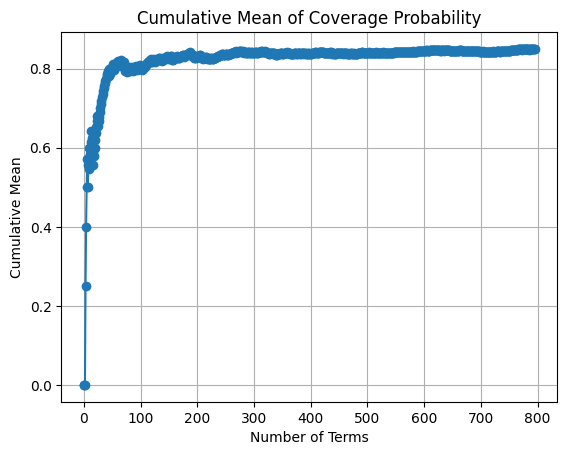

In [54]:
ACI_model_1.plot_coverage_probabilities(ACI_model_1.coverage)

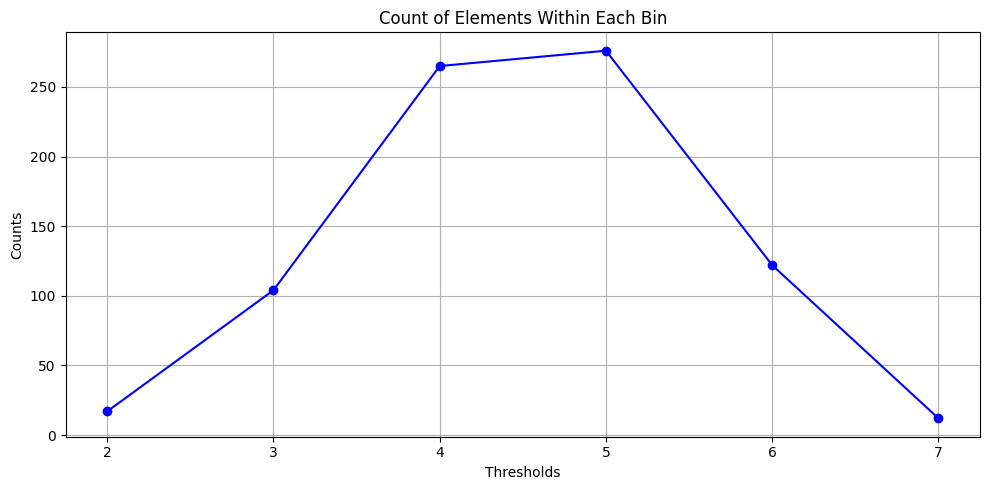

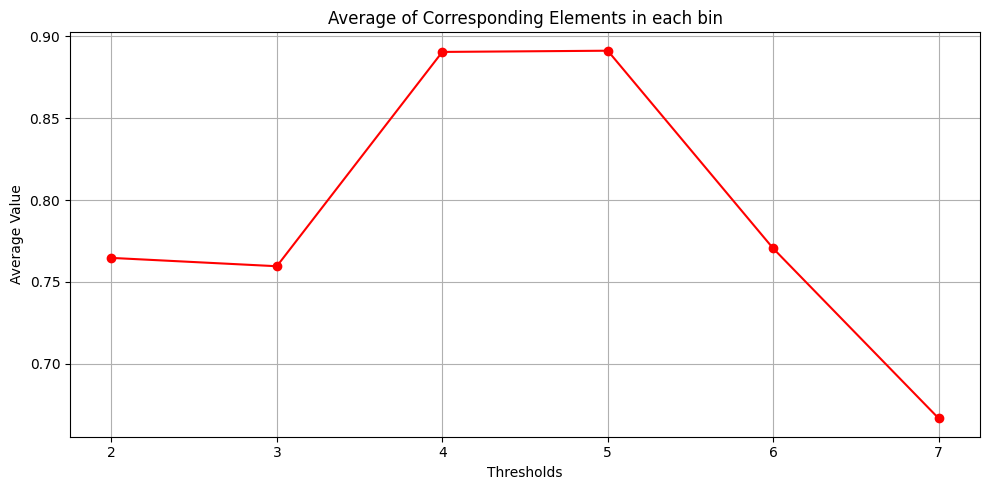

In [55]:
import matplotlib.pyplot as plt

# Your example lists (assuming ACI_model_1.X and ACI_model_1.coverage are your lists)
X = ACI_model_1.X[2:]  # Assuming this is a list-like object with your values
coverage = ACI_model_1.coverage # And this is your second list

thresholds = [2, 3, 4, 5, 6, 7]
counts = []
averages = []

for threshold in thresholds:
    # Find indices where elements are greater than the current threshold
    indices = [i for i, element in enumerate(X) if (element > threshold) and (element < threshold + 1)]
    
    # Use indices to extract the corresponding elements from the second list
    corresponding_elements = [coverage[index] for index in indices]
    
    # Calculate the average of these elements
    average = sum(corresponding_elements) / len(corresponding_elements) if corresponding_elements else 0
    
    # Store the count of elements and the average for plotting
    counts.append(len(indices))
    averages.append(average)

# Plotting the count of elements withiin each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, counts, marker='o', linestyle='-', color='b')
plt.title('Count of Elements Within Each Bin')
plt.xlabel('Thresholds')
plt.ylabel('Counts')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

# Plotting the average of corresponding elements in each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, averages, marker='o', linestyle='-', color='r')
plt.title('Average of Corresponding Elements in each bin')
plt.xlabel('Thresholds')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

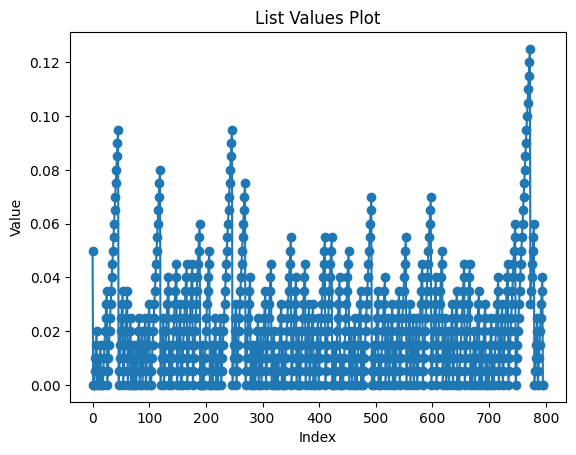

In [56]:
# Create a figure and a set of subplots
plt.figure()

# Plot the list values against their index
plt.plot(range(len(ACI_model_1.alpha_tilde)), ACI_model_1.alpha_tilde, marker='o')  # 'o' creates a circle marker

# Optionally, add labels and title
plt.title('List Values Plot')
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()

## ACI Binned 1

In [57]:
ACI_model_2 = ACI_Binned(X=X_train, y=y_train, ymin =0, ymax = ymax)
ACI_model_2.predict_intervals(cutoffs=[3, 4, 5, 6, 7])

In [58]:
ACI_model_2.coverage_probability()

0.8580402010050251

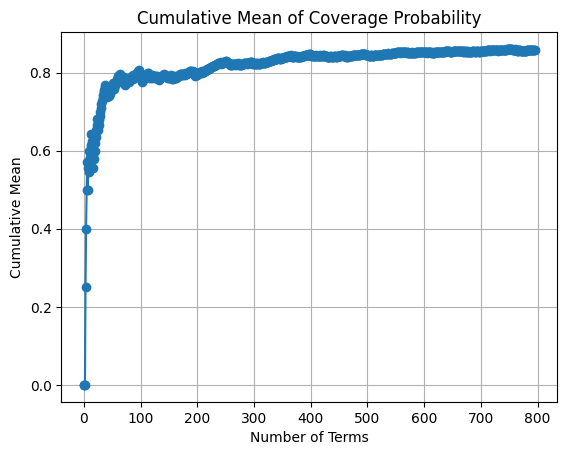

In [59]:
ACI_model_2.plot_coverage_probabilities(ACI_model_2.coverage_all)

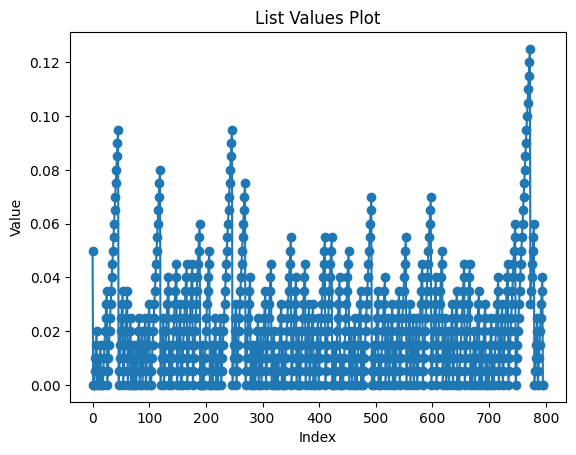

In [60]:
# Create a figure and a set of subplots
plt.figure()

# Plot the list values against their index
plt.plot(range(len(ACI_model_1.alpha_tilde)), ACI_model_1.alpha_tilde, marker='o')  # 'o' creates a circle marker

# Optionally, add labels and title
plt.title('List Values Plot')
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()

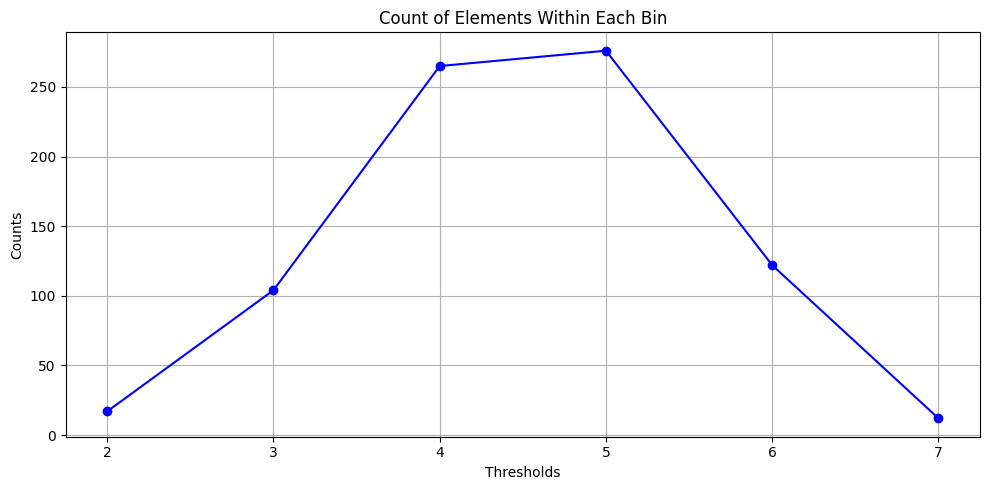

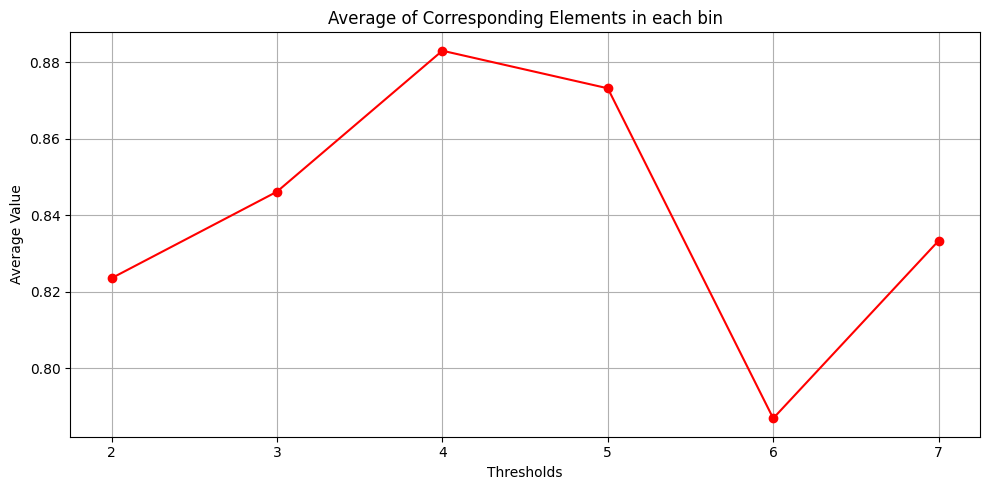

In [61]:
import matplotlib.pyplot as plt

# Your example lists (assuming ACI_model_1.X and ACI_model_1.coverage are your lists)
X = ACI_model_2.X[2:]  # Assuming this is a list-like object with your values
coverage = ACI_model_2.coverage_all  # And this is your second list

thresholds = [2, 3, 4, 5, 6, 7]
counts = []
averages = []

for threshold in thresholds:
    # Find indices where elements are greater than the current threshold
    indices = [i for i, element in enumerate(X) if (element > threshold) and (element < threshold + 1)]
    
    # Use indices to extract the corresponding elements from the second list
    corresponding_elements = [coverage[index] for index in indices]
    
    # Calculate the average of these elements
    average = sum(corresponding_elements) / len(corresponding_elements) if corresponding_elements else 0
    
    # Store the count of elements and the average for plotting
    counts.append(len(indices))
    averages.append(average)

# Plotting the count of elements withiin each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, counts, marker='o', linestyle='-', color='b')
plt.title('Count of Elements Within Each Bin')
plt.xlabel('Thresholds')
plt.ylabel('Counts')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

# Plotting the average of corresponding elements in each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, averages, marker='o', linestyle='-', color='r')
plt.title('Average of Corresponding Elements in each bin')
plt.xlabel('Thresholds')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()


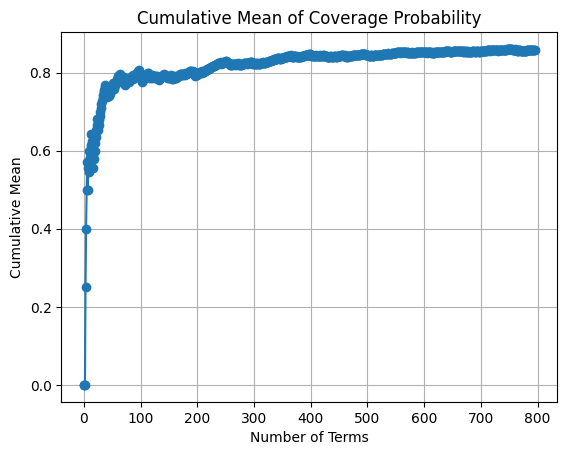

In [62]:
ACI_model_3 = ACI_Binned(X=X_train, y=y_train, ymin =0, ymax = 70)
ACI_model_3.predict_intervals(cutoffs=[4])
ACI_model_3.coverage_probability()
ACI_model_3.plot_coverage_probabilities(ACI_model_2.coverage_all)

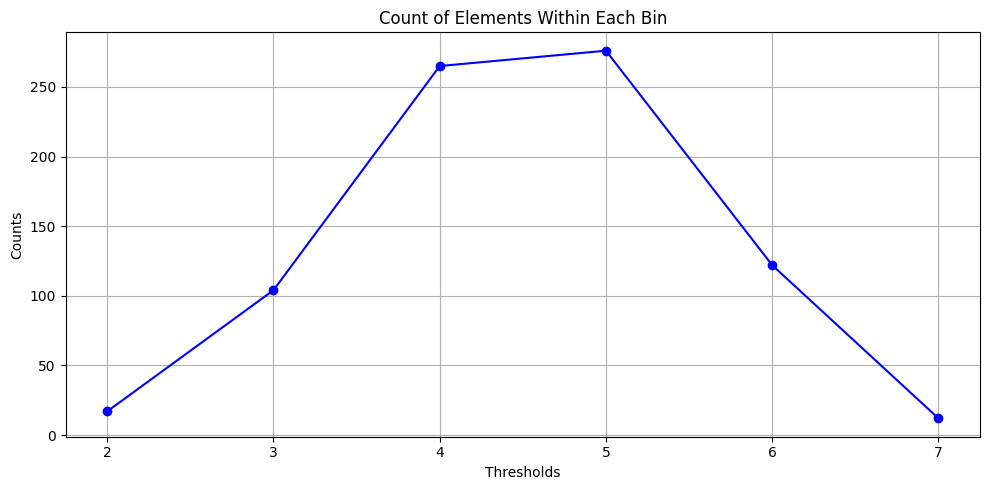

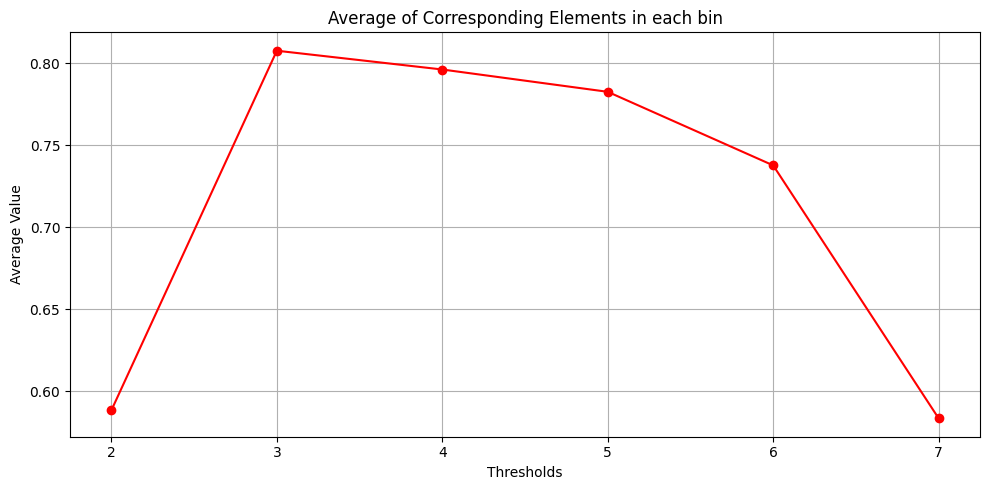

In [63]:
import matplotlib.pyplot as plt

# Your example lists (assuming ACI_model_1.X and ACI_model_1.coverage are your lists)
X = ACI_model_3.X[2:]  # Assuming this is a list-like object with your values
coverage = ACI_model_3.coverage_all  # And this is your second list

thresholds = [2, 3, 4, 5, 6, 7]
counts = []
averages = []

for threshold in thresholds:
    # Find indices where elements are greater than the current threshold
    indices = [i for i, element in enumerate(X) if (element > threshold) and (element < threshold + 1)]
    
    # Use indices to extract the corresponding elements from the second list
    corresponding_elements = [coverage[index] for index in indices]
    
    # Calculate the average of these elements
    average = sum(corresponding_elements) / len(corresponding_elements) if corresponding_elements else 0
    
    # Store the count of elements and the average for plotting
    counts.append(len(indices))
    averages.append(average)

# Plotting the count of elements withiin each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, counts, marker='o', linestyle='-', color='b')
plt.title('Count of Elements Within Each Bin')
plt.xlabel('Thresholds')
plt.ylabel('Counts')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

# Plotting the average of corresponding elements in each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, averages, marker='o', linestyle='-', color='r')
plt.title('Average of Corresponding Elements in each bin')
plt.xlabel('Thresholds')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()


In [68]:
class ACI_Binned_IPTW(ACI_Binned):
    def __init__(self, X, y, *args, **kwargs):
        super().__init__(X, y, *args, **kwargs)

    def predict_intervals_IPTW(self, cutoffs, propensity_score):
        n = self.X.shape[0]
        l = len(cutoffs) + 1
        assert l == 2
        assert l == len(propensity_score)
        y_range = np.linspace(self.ymin, self.ymax, 1000)
        self.coverage = [[] for _ in range(l)]
        self.alpha_tilde = [[self.alpha] for _ in range(l)]
        self.IPTW = propensity_score
        self.X_bins = np.array([int(bisect.bisect_left(cutoffs, self.X[i])) for i in range(len(self.X))])
        self.y_weighted = [[] for _ in range(l)]
        for i in range(2, n):
            # Update alpha tilde
            if self.X_bins[i-1]:
                self.y_weighted[self.X_bins[i-1]].append(self.y[i-1])
                self.y_weighted[1 - self.X_bins[i-1]].append(self.y[i-1] * self.IPTW[self.X_bins[i-1]])
            else:
                self.y_weighted[self.X_bins[i-1]].append(self.y[i-1] * self.IPTW[1-self.X_bins[i-1]])
                self.y_weighted[1 - self.X_bins[i-1]].append(self.y[i-1])
            for current_group in range(l):
                if self.coverage[current_group]:
                    self.alpha_tilde[current_group][-1] = self.alpha_tilde[current_group][-1] + self.gamma * (self.alpha + self.coverage[current_group][-1] - 1)
                self.alpha_tilde[current_group][-1] = min(1, max(0, self.alpha_tilde[current_group][-1]))
                # Initialize conformal predictor
                self.current_predictor = self.predictor(model=self.model, alpha=self.alpha_tilde[current_group][-1])
                # Generate the predicted interval
                intervals = self.current_predictor.predict_interval(self.X_bins[0:i].reshape(-1, 1), self.y[0:i], current_group, y_range)
                coverage = 0
                for i, interval in enumerate(intervals):
                    if (interval[0] < self.y_weighted[current_group][-1]) and (self.y_weighted[current_group][-1] < interval[1]):
                        coverage = 1
                        break
                self.coverage[current_group].append(coverage)
                self.coverage_all.append(coverage)
                self.alpha_tilde[current_group].append(self.alpha_tilde[current_group][-1])

In [69]:
ACI_model_4 = ACI_Binned_IPTW(X=X_train, y=y_train)
ACI_model_4.predict_intervals_IPTW(cutoffs=[4], propensity_score=[0.1587, 1-0.1587])

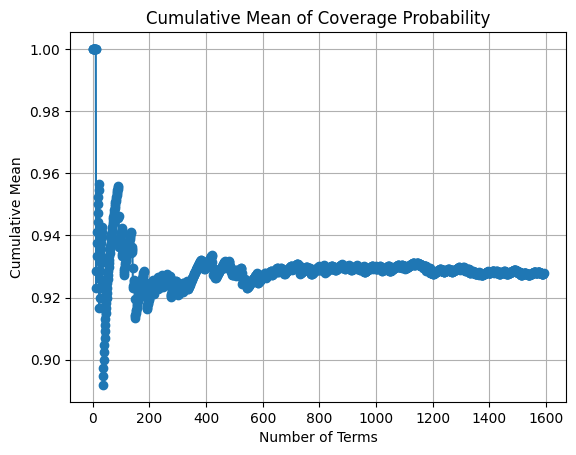

In [70]:
ACI_model_4.coverage_probability()
ACI_model_4.plot_coverage_probabilities(ACI_model_4.coverage_all)

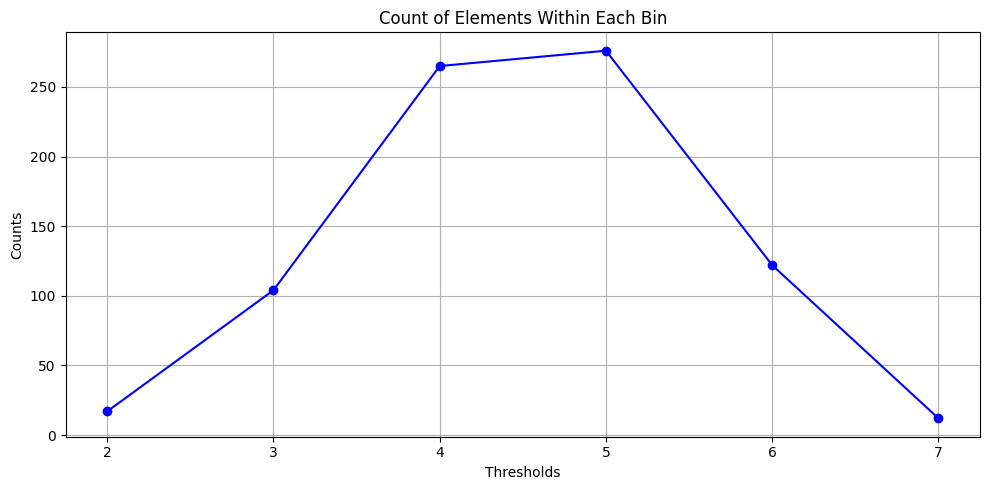

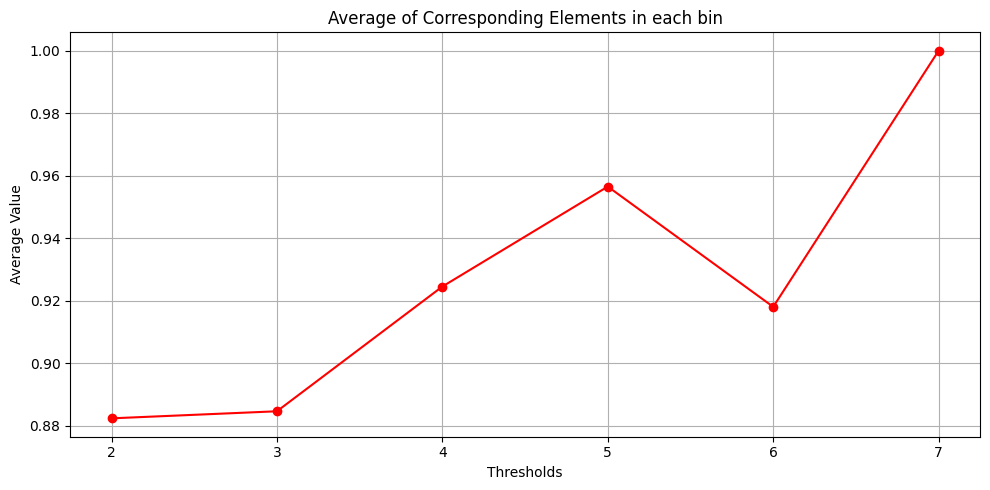

In [71]:
import matplotlib.pyplot as plt

# Your example lists (assuming ACI_model_1.X and ACI_model_1.coverage are your lists)
X = ACI_model_4.X[2:]  # Assuming this is a list-like object with your values
coverage = ACI_model_4.coverage_all  # And this is your second list

thresholds = [2, 3, 4, 5, 6, 7]
counts = []
averages = []

for threshold in thresholds:
    # Find indices where elements are greater than the current threshold
    indices = [i for i, element in enumerate(X) if (element > threshold) and (element < threshold + 1)]
    
    # Use indices to extract the corresponding elements from the second list
    corresponding_elements = [coverage[index] for index in indices]
    
    # Calculate the average of these elements
    average = sum(corresponding_elements) / len(corresponding_elements) if corresponding_elements else 0
    
    # Store the count of elements and the average for plotting
    counts.append(len(indices))
    averages.append(average)

# Plotting the count of elements withiin each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, counts, marker='o', linestyle='-', color='b')
plt.title('Count of Elements Within Each Bin')
plt.xlabel('Thresholds')
plt.ylabel('Counts')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

# Plotting the average of corresponding elements in each bin
plt.figure(figsize=(10, 5))
plt.plot(thresholds, averages, marker='o', linestyle='-', color='r')
plt.title('Average of Corresponding Elements in each bin')
plt.xlabel('Thresholds')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()
